# Section 6 - Graphically Supported Hypotheses

In [1]:
library(data.table)
library(ggplot2)
library(tidyr)
library(magrittr)
library(gridExtra)
library(devtools)

# devtools::install_github("easystats/correlation")
library(correlation)


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: usethis


In [2]:
# --------------------

## Descriptive vs. Associative Plots

### 1. Descriptive Plots

For exploration how variable (or set of variables) distributes. Plot corresponds to descriptions of distribution $p(X)$ ($X$ should be explored).

In ML: correspond to unsupervised learning methods (k-means/hierarchical clustering, PCA, ...).

---

*Univariate data*: histogram, single boxplot, violin plot, ...

*Multivariate data*: clustered heatmap, PCA projection, ...

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


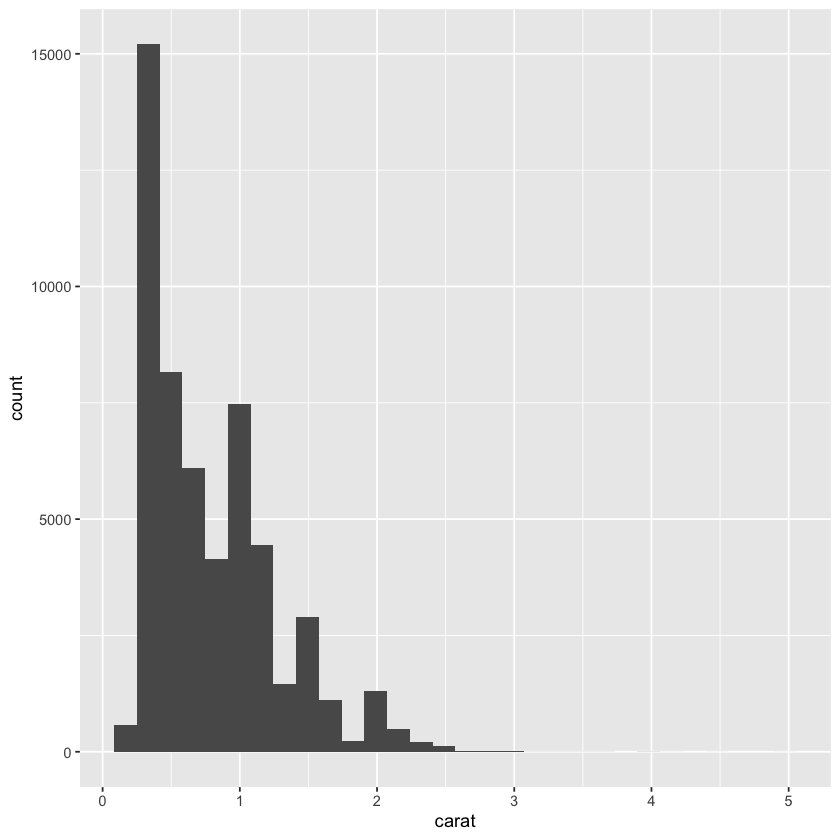

In [3]:
# example: visualize distribution of weights (carat)
ggplot(diamonds, aes(carat)) +
    geom_histogram()

### 2. Associative Plots

Show how one variable depends on another/others. Graphical representation of conditional distribution $p(y|x)$ ($x$ is explanatory variable, $y$ is response).

In ML: correspond to supervised learning methods (regression, classification, ...).

---

Use y-axis for response variable and x-axis for explanatory variables.

Plots: side-by-side boxplots (can e.g. show that characteristic values of distribution of response depend on those on the explanatory variable), scatterplot (can e.g. show how response increases in average as explanatory variable increases), ...

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


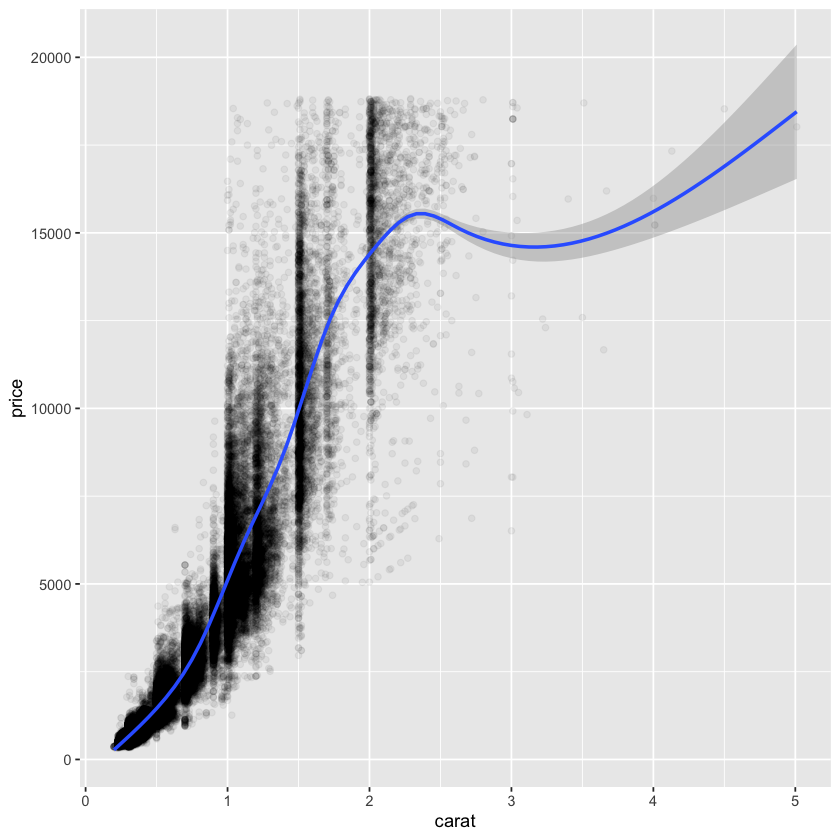

In [4]:
# example: price increases with increasing weight
ggplot(diamonds, aes(carat, price)) + 
    geom_point(alpha = 0.05) +             # alpha: point transparency
    stat_smooth()

### 3. Correctly Using Descriptive and Demonstrative Plots

Formulate claims based on associative plot between response variable (on y-axis) against dependent variable (on x-axis).

---

example: PCA is visualization designed to capture joint distribution of all data and not to assess reproducibility between given pair of samples. Boxplot can show distribution of correlation between pairs of samples (y-axis) for two categories.

In [5]:
# --------------------

## Correlation and Causation

Goal of data analysis: provide hypothesis about underlying causal mechanisms.

Causal conclusions: established in specific cases, data gather in (randomized) controlled fashion (e.g. vary only one variable).

---

Problem: often only uncontrolled data, hence can access statistical dependencies/associations between variables (correlations, enrichments, ...), but cannot determine causal links.

Elementary situations of non-causal association:
- association not statistically supported
- reverse causal relationship
- association induced by third variable

---

Note: associations between variables not due to a causal relationship are "spurious correlations".

### 1. Association is not Statistically Supported

Often: observed association arose by change, i.e. will probably not appear if for example more data was available.

Two main reasons:
1. associations driven by few data points -> showing outliers or hypothesis testing can help
2. data set has many variables, hence the chances of one pair associating is high ("data dredging"). See for example Figure 6.2 on http://www.tylervigen.com/spurious-correlations.

### 2. Reversing Cause and Effect

Statistical dependencies symmetric, hence typical mistake: claims where cause and effect are reversed.

Examples:
- People with healthier diet have higher blood pressure.
- Individuals in a low social status have a higher risk of schizophrenia.

---

No firm way to decide direction of causality based on only association, always cinsider/discuss both possibilities!

### 3. Association is Induced by a Third Variable

Problem: association due to third variable

Possible cases, where $z$ could be casually related to $x$ and $y$:
- common cause: $z \rightarrow x$ and $z \rightarrow y$, conditional (in)dependece: $(x \perp y)|z$
- indirect cause: $x \rightarrow z \rightarrow y$, conditional (in)dependece: $(x \perp y)|z$
- common consequence: $x \rightarrow z$ and $y \rightarrow z$, conditional (in)dependece: $(x \not\perp y)|z$

Notation: $x \perp y$ means $x$ and $y$ are statistically independent

#### 3.1 Common Cause

Can cause statistical dependencies. Plots help to identify certain situations, for example by statifying by one variable and showing that the positive association vanishes.

---

*Example*

Process (repeated $n = 1000$ times):
1. toss fair coin twice and count the number of heads: $z \in \{0, 1, 2\}$
2. Draw value $x$ randomly according to Gaussian distribution with mean equal $z$ and standart deviation 1.
3. Draw value $y$ randomly according to Gaussian distribution with mean equal $2 \cdot z$ and standart deviation 1.

Note: $x$ and $y$ tend to have higher values with higher values of $z$.

In [6]:
##################
## common cause ##
## x <- z -> y  ##
##################

# generation
set.seed(0)

n <- 1000 # number of draws

# z: n draws of the binomial
# with 2 trials and prob=0.5 
z <- rbinom(n, 2, prob=0.5) 

# x: Gaussian with mean z
x <- rnorm(n, mean=z, sd=1)

# y: Gaussian with mean 2*z
y <- rnorm(n, mean=2*z, sd=1)

# gather into a data table
# we make z a factor for convenience with plotting functions
dt <- data.table(x, y, z = factor(paste0("z=",z)))


In [7]:
# simulation worked: 25% draws with 0 heads, 50% draws with 1 head, 25% draws with 2 heads
table(z)

z
  0   1   2 
244 506 250 

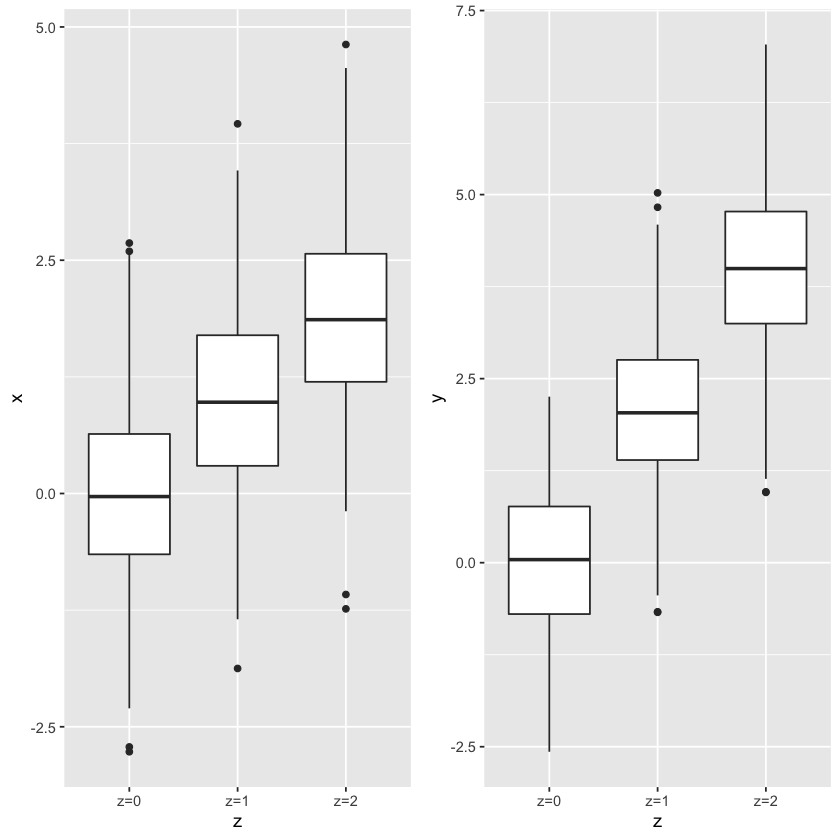

In [8]:
# show: x and y both depend on z!
grid.arrange(
    ggplot(dt, aes(x=z, y=x)) + geom_boxplot(),
    ggplot(dt, aes(x=z, y=y)) + geom_boxplot(),
    ncol=2, nrow=1)

[1] 0.4535741

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


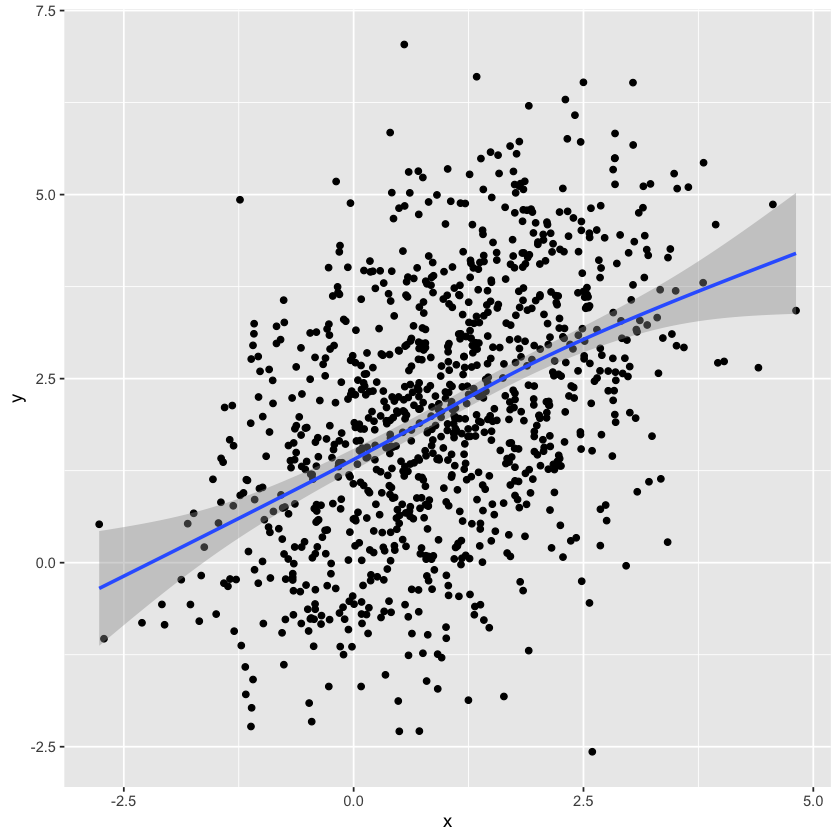

In [9]:
# consequence: x and y correlate
cor(x,y)

ggplot(dt, aes(x=x, y=y)) +
    geom_point() +
    geom_smooth()

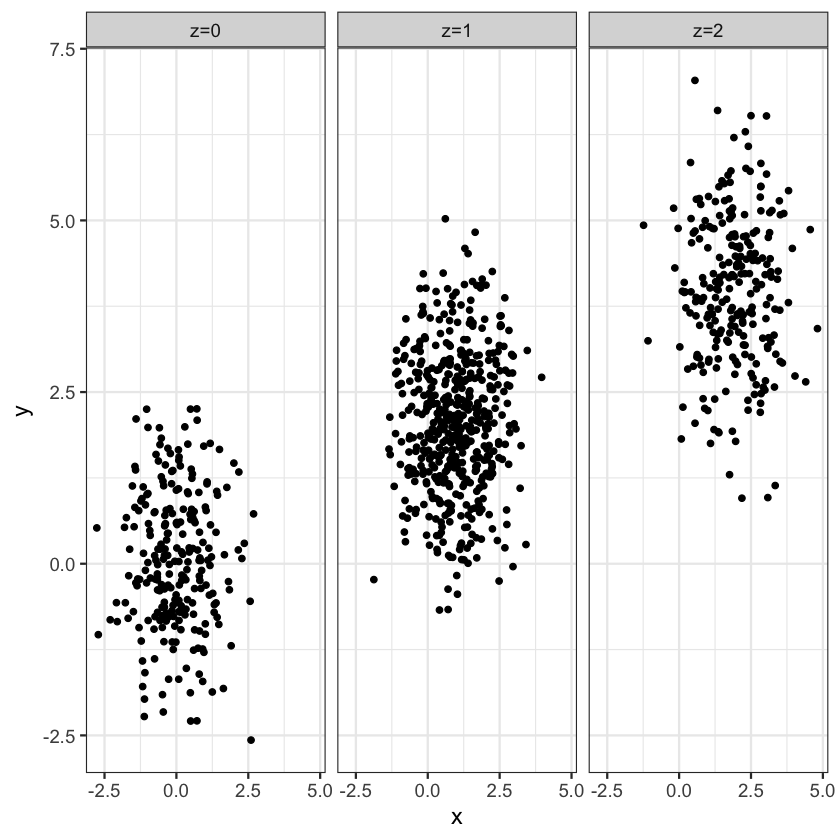

In [10]:
# but: correlation only due to common cause z!
# idea: plot statified by values of z and show thatno association exists between x and y
ggplot(dt, aes(x=x, y=y)) +
    geom_point() +
    facet_wrap(~z) +
    theme_bw(base_size = 14)

In [11]:
# correlation stratified by value of z also shows the same result
dt[, .(correlation=cor(x,y)), by=z]

z,correlation
z=2,-0.0005907227
z=1,0.0457336976
z=0,-0.0107107309


#### 3.2 Indirect Association

Plots help to identify certain situations, for example by conditioning on the "third variable".

---

*Example*

Process:
1. Toss coin, $x=0$ if it's tail, $x=1$ if it's head.
2. Toss coin $x+1$ times. $z$ is number of heads in this step.
3. Draw value $y$ randomly according to Gaussian distribution with mean equal $z$ and standart deviation 0.5.

Note: another example in script :)

In [12]:
# generation

# first step:  tossing a coin once
# record x=1 if head, x=0 if tail.
x <- rbinom(n, size=1, prob=0.5)

# second step
# if x=0, toss the coin once, if x=1, toss the coins twice
# record z the number of heads of this second step. 
z <- rbinom(n, size=x+1, prob=0.5) 

## y: Gaussian with mean=z
y <- rnorm(n, mean=z, sd=0.5)

dt <- data.table(
  x = factor(paste0("x=",x)),
  y, 
  z = factor(paste0("z=",z))
)

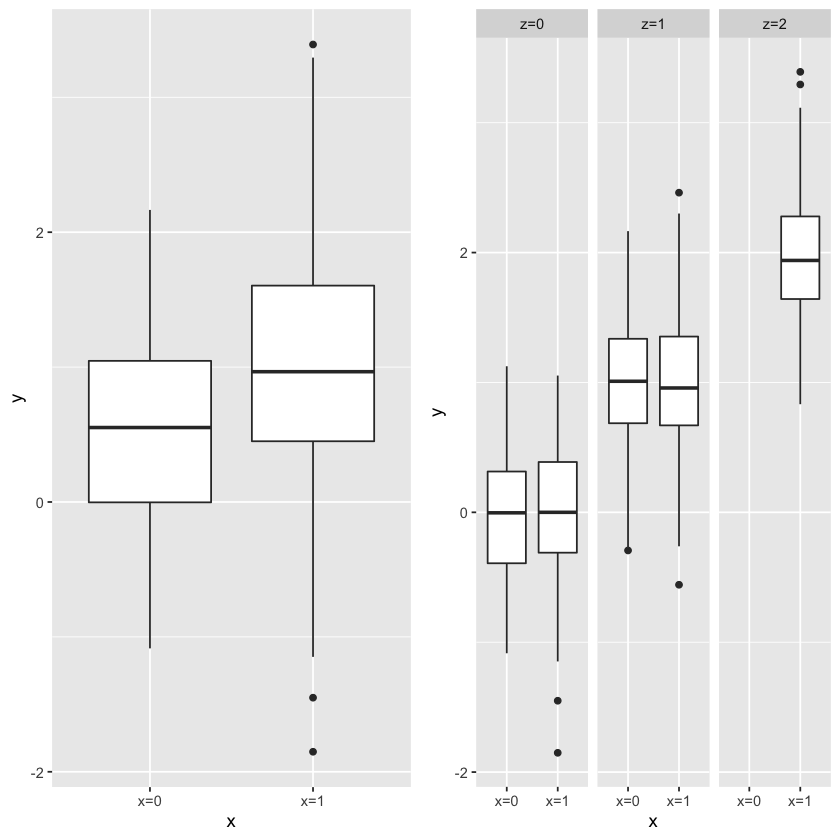

In [13]:
# x associated with y, but association vanishes when condition on z
grid.arrange(
    ggplot(dt, aes(x=x, y=y)) + geom_boxplot(),
    ggplot(dt, aes(x=x, y=y)) + geom_boxplot() + facet_wrap(~z),
    ncol=2, nrow=1)

#### 3.3 Common Consequence

Association arises when conditioned on "third variable". Should be considered when reporting associations between variables.

Implications:
1. don't condition systematically.
2. data may be condition, even if we don't know it.

---

*Example*

Process:
1. Draw value $x$ randomly according to Gaussian distribution with mean 0 and standart deviation 1.
2. Draw value $y$ randomly according to Gaussian distribution with mean 0 and standart deviation 1 (independently of x).
3. $z=1$ if $x+y > 1$.

Note: $x$ and $y$ tend to have higher values with higher values of $z$.

[1] -0.03192247

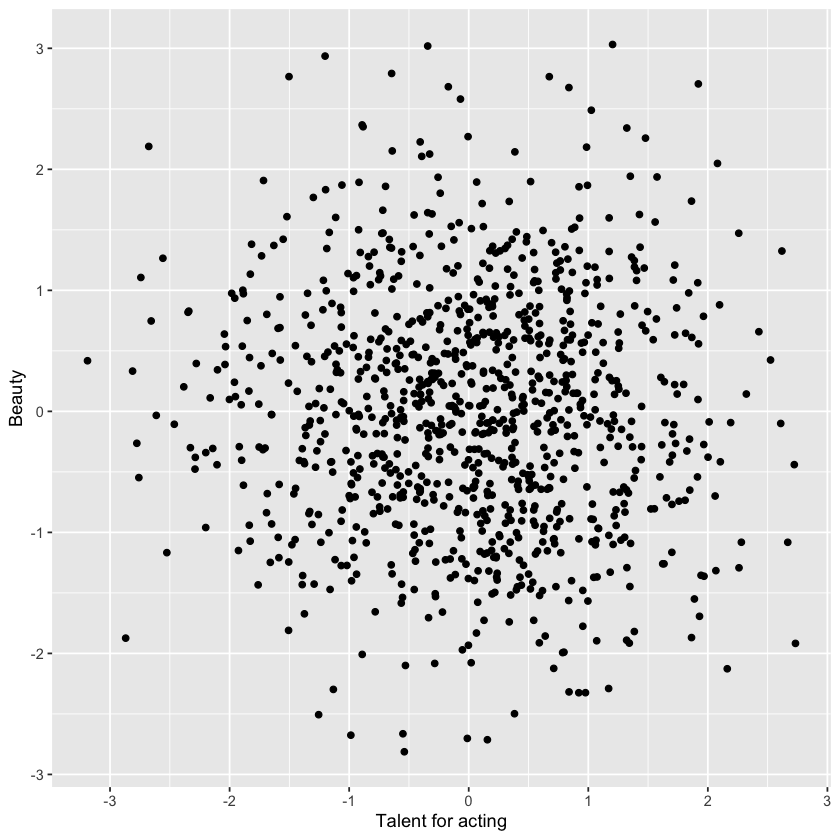

In [14]:
########################
## common consequence ##
##     x->z<-y        ##
########################

# generation
x <- rnorm(n)  # talent for acting
y <- rnorm(n)  # beauty
z <- x+y > 1  

dt <- data.table(x, y, z)

# no correaltion between x and y
cor(x, y)
ggplot(dt, aes(x=x, y=y)) +
    geom_point() +
    labs(x = 'Talent for acting', y = 'Beauty')

[1] -0.5843082

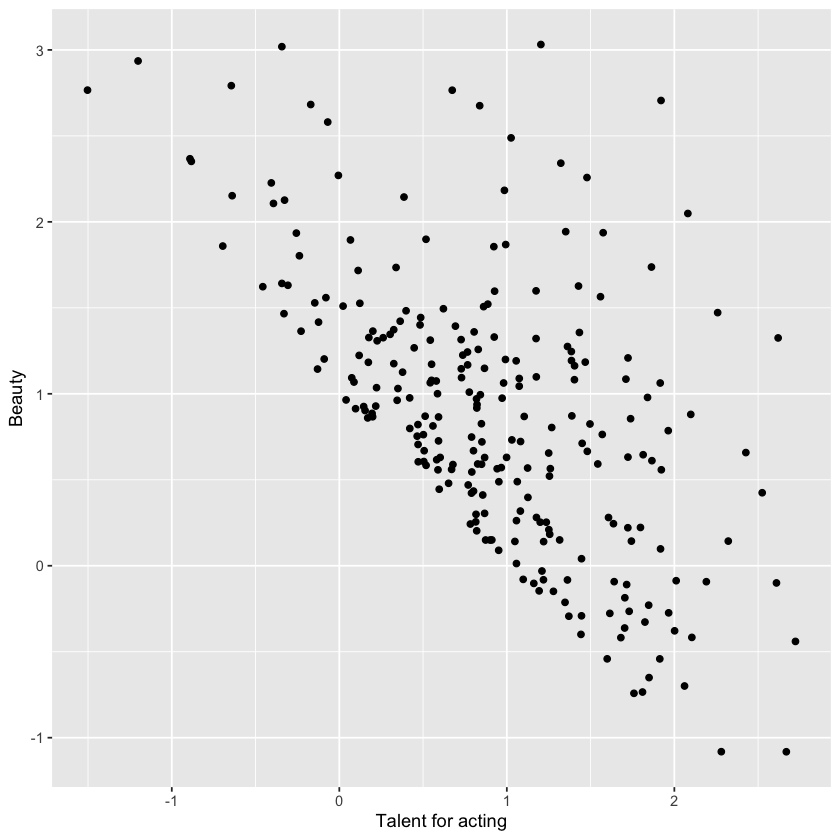

In [15]:
# Berkson's paradox: x associates with y when analysis restricted
dt[z, cor(x,y)]
ggplot(dt[z == TRUE], aes(x=x, y=y)) + geom_point() + labs(x = 'Talent for acting', y = 'Beauty')

### 4. Simpson’s Paradox

Statistical relationship observed within group of individuals can be reversed within all subgroups making up the population.

Phenomenon description: variable X seems to relate to variable Y in a certain way, but flips direction when stratifying for another variable Z

In [16]:
# generation
data <- simulate_simpson(n = 100, groups = 4, r = 0.6) %>% as.data.table
colnames(data) <- c('X', 'Y', 'Z')
data %>% head()

X,Y,Z
0.7571442,-0.2531470,G_1
1.3253338,0.2617510,G_1
1.1057654,-1.0828252,G_1
0.1859743,-0.3760158,G_1
2.1004333,1.5311882,G_1
0.1375031,-1.0966566,G_1


`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


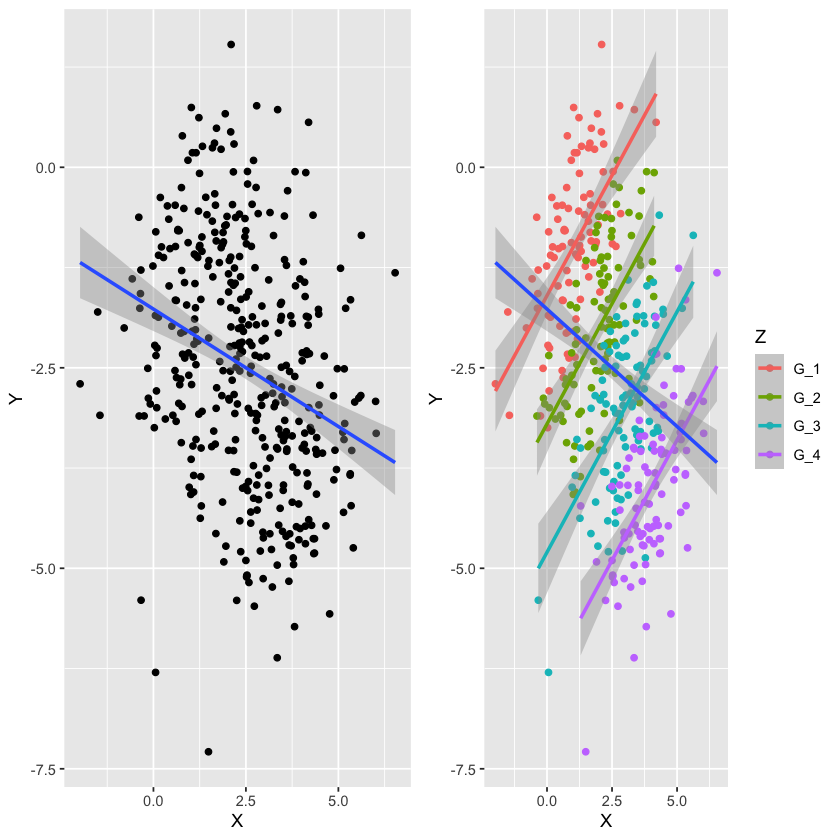

In [17]:
# X and Y are negatively correlated
# but if gruoped by Z, a positive correlation can be seen
grid.arrange(
    ggplot(data, aes(X, Y)) +
        geom_point() +
        geom_smooth(method='lm'),
    ggplot(data, aes(x = X, y = Y)) +
        geom_point(aes(color = Z)) +
        geom_smooth(aes(color = Z), method = "lm") +
        geom_smooth(method = "lm"),
    ncol=2, nrow=1)

In [18]:
# --------------------

## Data Presentation as Story Telling

Essential, but underestimated. Consider background and interests of audience to choose fitting, clear and efficient representation of analysis, s.t. message is clear and exciting.

### 1. What is a Story?

Story: set of observation, facts or events presented in order to create emotional reaction in audience via build-up of tension followed by resolution (i.e. via a story-arc).

Order: introduce topic, present challenges and actions, present resolution.

### 2. Presentation Structure

#### 2.1 Introduction

State motivation of topic, give overview on background needed to understand data and state goals of presentation.

Include open questions here.

#### 2.2 Development

Transform hypotheses, claims and results into slides.

---

Avoid misconceptions:
1. Audience can see figure and immediately infer points we want to make.
2. Audience can process complex visualization and understand key trends/relationships

Therefore: help audience to understand meaning of visualization and to see patterns in data.

If complex figure needed: show a simlpified version first.

---

Show first descriptive plots to present data. Then associative plots to support claims, results, hypotheses.

Ideally: one slide per claim supported by plot (choose type carefully!!). Include titles in slides and plots for a simpler interpretation, i.e. include interpretation in title.

Warning message:
“Removed 4 rows containing missing values (geom_point).”`geom_smooth()` using formula 'y ~ x'
Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 7 rows containing missing values (geom_point).”

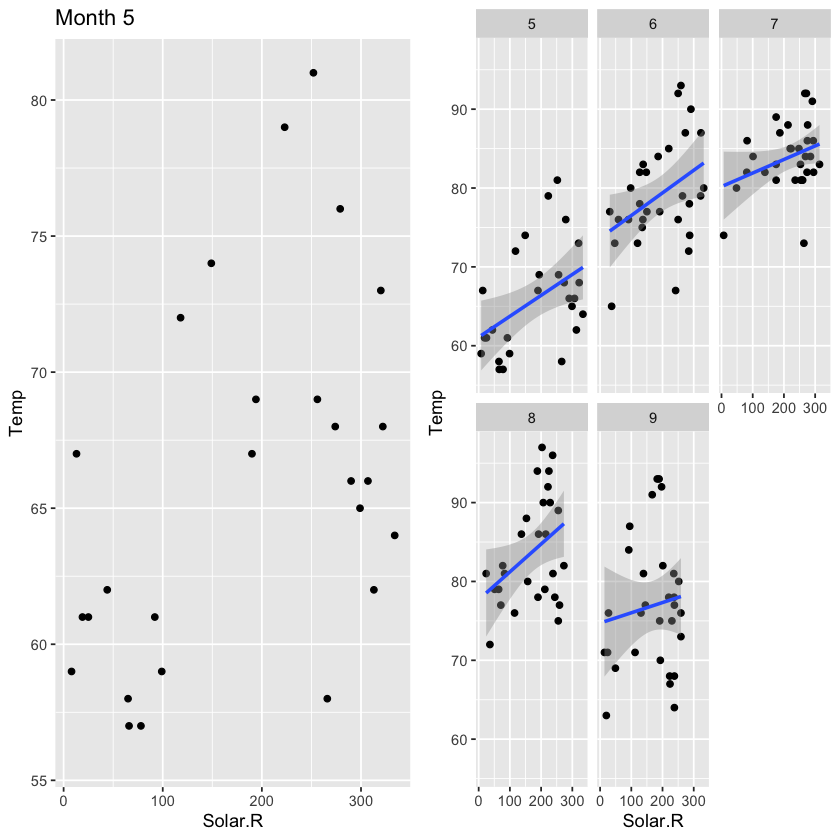

In [28]:
# examples for simple and more complex figures
airquality <- as.data.table(airquality)
grid.arrange(
    ggplot(airquality[Month==5], aes(Solar.R, Temp)) +
        geom_point() +
        labs(title='Month 5'),
    ggplot(airquality, aes(Solar.R, Temp)) +
        geom_point() +
        facet_wrap(~Month) +
        stat_smooth(method='lm'),
    ncol=2, nrow=1)

#### 2.3 Closure

Strong closure.

Summarize presentation including clear conclusion (what do we learn from data analysis?), then provide outlook (possible next steps, etc.).

In [19]:
# --------------------

## Guidelines for Coloring in Data Visualization

### 1. Color Coding in R

Options in `ggplot2`:
- default colors
- set color names ("red", "blue", ...)
- set RGB/HTML color codes
- set explicit color palette

---

Color palettes: use `RColorBrewer`.

sequential palettes: continuous variables

qualitative palettes: categorical variables

diverging palettes: numeric values

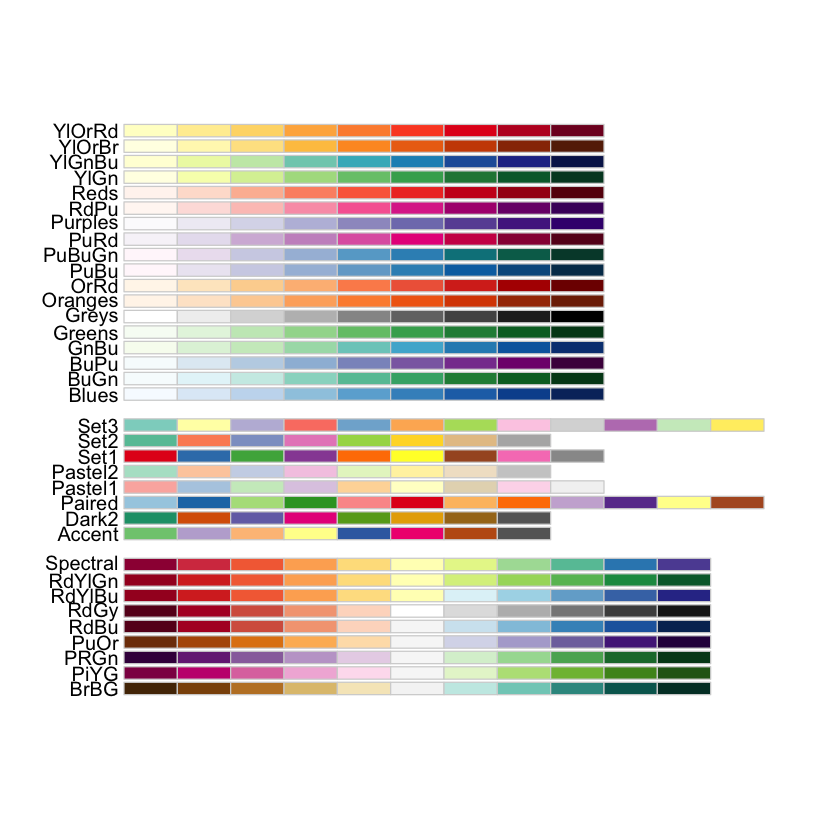

In [20]:
library("RColorBrewer")
display.brewer.all()

### 2. General Rules for Color Coding

**Rule #1**: consistent background

Especially important if different colors are used in the objects.

---

**Rule #2**: sufficient contrast for visibility

---

**Rule #3**: meaningful color usage

Use color coding only if necessary, i.e. to provide additional information.

---

**Rule #4**: color usage with restraint

Use different colors if the correspond to differences of meaning in data.

---

**Rule #5**: less is more

Use `soft` colors and `highligh` with `bright` colors only if necessary.

---

Conclusion: use colors with precaution

In [21]:
# --------------------

## General Do’s and Don’ts in Data Visualization

### 1. Do's

*Say the most with the least.*

**Keep visualizations simple**

Good plots have simple messages and are simple to understand. Do not represent too much information.

---

**Have meaningful and expressive titles**

Add titles, etc. decribing the visialized data and the result via `labs()`.

---

**Always label the axes**

Labels should be large enough. Also label everything else, like colors or shapes.

---

**Always keep the goal of the visualization on mind**

Focus on story, claims and conclusions.

---

**Know when to include 0**

### 2. Don'ts

- double encoding
- heavy/dark grid lines
- unnecessary text
- ornamented chart axes
- pictures with graphs
- shading/pseudo 3D plots

(https://www.darkhorseanalytics.com/blog/data-looks-better-naked/)

---

Additionally: avoid 3D-plots, use color coding or something similar instead. Do not manipulate plots.

##### End of Section 6!